<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/2_Duolingo_preprocessing_wordEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color = 'cornflowerblue' size=4>Preprocessing and word features EDA Plan</font>

The previous notebook covered basic EDA and transforming of the target variable and time based variables. 

In this notebook, the lexeme strings are transformed.

Then, various word-based features are investigated as predictors of forgetting a word:
1. word length 
2. The Inverse Document Frequency value of a word.
3. string distance measures of similarity between a word and its meaning in the native language

The above features are stored in a separate dataframe, and will be joined with the training and testing sets separately. 

After splitting, in a separate notebook, the following features are considered:
4. The modifiers included in the lexeme strings

Since thee features are dependent on the training set data, and the columns generated will depend on the data that can be seen, getting these features followed by dimension reduction,will be wrapped in custom functions that fit the train and transform test and train based on the data only in the train sets. 

An alternative feature set will also be considered in a different notebook:
6. multilingual word embeddings. + the rest. 

Loading data:

In [1]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
datadf = decompress_pickle(path_name+"Duolingo_pforgotbin.pbz2") 

## <font color = 'cornflowerblue' size = 4>Decomposing lexeme_strings</font>
Information on the contents of the lexeme string are in a [github repository](https://github.com/duolingo/halflife-regression).

Relevant bits are reproduced here:

The lexeme_string column contains a string representation of the "lexeme tag" used by Duolingo for each lesson/practice ...  The lexeme_string field uses the following format:
```
surface-form/lemma<pos>[<modifiers>...]
```

Where:
surface-form: refers to the inflected form seen in (or intended for) the exercise,<br> 
lemma: is the uninflected root,<br> 
pos: is the high-level part of speech,<br> 
modifers: each encodes a morphological component specific to the surface form (tense, gender, person, case, etc.).<br> 

A few examples from Spanish:
```
bajo/bajo<pr>
blancos/blanco<adj><m><pl>
carta/carta<n><f><sg>
```
Some tags contain wildcard components, written as \<\*...\>. For example, <*sf> refers to a "generic" lexeme without any specific surface form (e.g., a lexeme tag that represents all conjugations of a verb: "run," "ran," "running," etc.). 

The <*numb> modifier subsumes both singular and plural forms of a noun (e.g., "teacher" and "teachers"). 

The file [lexeme_reference.txt](https://github.com/duolingo/halflife-regression/blob/master/lexeme_reference.txt) contains a reference of pos and modifier components used for lexeme tags.

The decomposed lexemes will be saved in a separate dataframe indexed by lexeme_id, and joined during training and testing separately based on the feature sets used. 

In [3]:
# getting all unique lexeme ids, and their strings and language
all_lexemes = datadf.loc[:,['lexeme_id','learning_language','lexeme_string']].drop_duplicates()

In [4]:
all_lexemes.shape

(19279, 3)

There are 19,279 unique words (counting repeated words in each language as separate).

Decomposing the lexeme string into individual features:

In [5]:
# separating out surface form and the rest
all_lexemes['surface_form'] = all_lexemes['lexeme_string'].apply(lambda x: x[0:x.find('/')])
all_lexemes['not_surface_form'] = all_lexemes['lexeme_string'].apply(lambda x: x[x.find('/')+1:])

all_lexemes.head()

,lexeme_id,learning_language,lexeme_string,surface_form,not_surface_form
0,76390c1350a8dac31186187e2fe1e178,de,lernt/lernen<vblex><pri><p3><sg>,lernt,lernen<vblex><pri><p3><sg>
1,7dfd7086f3671685e2cf1c1da72796d7,de,die/die<det><def><f><sg><nom>,die,die<det><def><f><sg><nom>
2,35a54c25a2cda8127343f6a82e6f6b7d,de,mann/mann<n><m><sg><nom>,mann,mann<n><m><sg><nom>
3,0cf63ffe3dda158bc3dbd55682b355ae,de,frau/frau<n><f><sg><nom>,frau,frau<n><f><sg><nom>
4,84920990d78044db53c1b012f5bf9ab5,de,das/das<det><def><nt><sg><nom>,das,das<det><def><nt><sg><nom>


In [6]:
# separating out lemma form and the rest
all_lexemes['lemma_form'] = all_lexemes['not_surface_form'].apply(lambda x: x[:x.find('<')])
all_lexemes['not_lemma_form'] = all_lexemes['not_surface_form'].apply(lambda x: x[x.find('<'):])
all_lexemes.head()

,lexeme_id,learning_language,lexeme_string,surface_form,not_surface_form,lemma_form,not_lemma_form
0,76390c1350a8dac31186187e2fe1e178,de,lernt/lernen<vblex><pri><p3><sg>,lernt,lernen<vblex><pri><p3><sg>,lernen,<vblex><pri><p3><sg>
1,7dfd7086f3671685e2cf1c1da72796d7,de,die/die<det><def><f><sg><nom>,die,die<det><def><f><sg><nom>,die,<det><def><f><sg><nom>
2,35a54c25a2cda8127343f6a82e6f6b7d,de,mann/mann<n><m><sg><nom>,mann,mann<n><m><sg><nom>,mann,<n><m><sg><nom>
3,0cf63ffe3dda158bc3dbd55682b355ae,de,frau/frau<n><f><sg><nom>,frau,frau<n><f><sg><nom>,frau,<n><f><sg><nom>
4,84920990d78044db53c1b012f5bf9ab5,de,das/das<det><def><nt><sg><nom>,das,das<det><def><nt><sg><nom>,das,<det><def><nt><sg><nom>


In [7]:
# separating out part of speech 'pos' and the rest
all_lexemes['pos'] = all_lexemes['not_lemma_form'].apply(lambda x: x[x.find('<')+1:x.find('>')])
all_lexemes['not_pos'] = all_lexemes['not_lemma_form'].apply(lambda x: x[x.find('>')+1:])
all_lexemes.head()

,lexeme_id,learning_language,lexeme_string,surface_form,not_surface_form,lemma_form,not_lemma_form,pos,not_pos
0,76390c1350a8dac31186187e2fe1e178,de,lernt/lernen<vblex><pri><p3><sg>,lernt,lernen<vblex><pri><p3><sg>,lernen,<vblex><pri><p3><sg>,vblex,<pri><p3><sg>
1,7dfd7086f3671685e2cf1c1da72796d7,de,die/die<det><def><f><sg><nom>,die,die<det><def><f><sg><nom>,die,<det><def><f><sg><nom>,det,<def><f><sg><nom>
2,35a54c25a2cda8127343f6a82e6f6b7d,de,mann/mann<n><m><sg><nom>,mann,mann<n><m><sg><nom>,mann,<n><m><sg><nom>,n,<m><sg><nom>
3,0cf63ffe3dda158bc3dbd55682b355ae,de,frau/frau<n><f><sg><nom>,frau,frau<n><f><sg><nom>,frau,<n><f><sg><nom>,n,<f><sg><nom>
4,84920990d78044db53c1b012f5bf9ab5,de,das/das<det><def><nt><sg><nom>,das,das<det><def><nt><sg><nom>,das,<det><def><nt><sg><nom>,det,<def><nt><sg><nom>


Only modifiers are leftover in the 'not_pos' column.

Saving the modifiers as a list:

In [8]:
all_lexemes['modstrings'] = all_lexemes['not_pos'].apply(lambda x: [y[y.find('<')+1:] for y in x.split('>') if len(y)>=1])
try:
  all_lexemes = all_lexemes.drop(['not_surface_form','not_lemma_form','not_pos'],axis=1)
except:
  pass
all_lexemes.head()

,lexeme_id,learning_language,lexeme_string,surface_form,lemma_form,pos,modstrings
0,76390c1350a8dac31186187e2fe1e178,de,lernt/lernen<vblex><pri><p3><sg>,lernt,lernen,vblex,"[pri, p3, sg]"
1,7dfd7086f3671685e2cf1c1da72796d7,de,die/die<det><def><f><sg><nom>,die,die,det,"[def, f, sg, nom]"
2,35a54c25a2cda8127343f6a82e6f6b7d,de,mann/mann<n><m><sg><nom>,mann,mann,n,"[m, sg, nom]"
3,0cf63ffe3dda158bc3dbd55682b355ae,de,frau/frau<n><f><sg><nom>,frau,frau,n,"[f, sg, nom]"
4,84920990d78044db53c1b012f5bf9ab5,de,das/das<det><def><nt><sg><nom>,das,das,det,"[def, nt, sg, nom]"


The lexeme strings have been decomposed. The dataframe is saved as a compressed pickle file in google drive, and joined later to the training or test splits for one hot encoding depending on the feature set. 

In [9]:
#compressed_pickle(path_name+"Duolingo_all_lexemes",all_lexemes)

## <font color = 'cornflowerblue' size = 4>EDA and feature selection with word-related features</font>

### <font color = 'cornflowerblue' size = 3>Is word length related to ease of learning a word?</font>

Word length can be computed as the number of characters in the surface form.

(In cases where there is no single surface form, such as those marked by <\*sf>, the lemma form is used instead.  

First, words containing non-alphabetic characters are listed below:

In [10]:
# getting counts of words that have non alphabetic characters
all_lexemes.loc[all_lexemes['surface_form'].apply(lambda x: not x.isalpha()),'surface_form'].value_counts()

<*sf>               5595
qu'                   14
l'                     7
c'                     2
s'                     2
d'                     2
sessant'               1
quatre-vingts          1
un'                    1
dix-huit               1
quest'                 1
quell'                 1
qualcos'               1
quarta-feira           1
settant'               1
trent'                 1
sexta-feira            1
por favor              1
buenas noches          1
quelqu'un              1
quinta-feira           1
terça-feira            1
quatre-vingt-dix       1
soixante-dix           1
quarant'               1
grand-mère             1
neanch'                1
buenos días            1
nell'                  1
t'                     1
dall'                  1
'                      1
's                     1
dell'                  1
j'                     1
d'accord               1
m'                     1
jusqu'à                1
sull'                  1
senz'                  1


There are 5595 lexeme ids with a generic surface form. The lemma for will be used for those. 

Apart from that, there are a number of words that include hyphens and apostrophes. These are left in as is, and are counted as one character each towards word length.

In [11]:
# computing word length as length of surface form
all_lexemes['sf_length'] = all_lexemes['surface_form'].apply(len)
# replacing word length for <*sf> words:
all_lexemes.loc[all_lexemes['surface_form']=='<*sf>','sf_length'] = all_lexemes.loc[all_lexemes['surface_form']=='<*sf>','lemma_form'].apply(len)

In [12]:
all_lexemes[['surface_form','sf_length']].head(5)

,surface_form,sf_length
0,lernt,5
1,die,3
2,mann,4
3,frau,4
4,das,3


Checking the wildcard surface form lengths:

In [13]:
all_lexemes.loc[all_lexemes['surface_form']=='<*sf>',['surface_form','lemma_form','sf_length']].head(10)

,surface_form,lemma_form,sf_length
72,<*sf>,traje,5
73,<*sf>,chapéu,6
74,<*sf>,fantasia,8
75,<*sf>,sapato,6
76,<*sf>,agasalho,8
77,<*sf>,camisa,6
78,<*sf>,vestir,6
79,<*sf>,relógio,7
80,<*sf>,média,5
81,<*sf>,vestido,7


The lemma forms have correctly been processed for word length in case of wildcard surface forms. 

Joining word length to main dataframe:

In [14]:
datadf['sf_length'] = datadf['lexeme_id'].map(dict(zip(all_lexemes['lexeme_id'],all_lexemes['sf_length'])))

In [15]:
datadf[['lexeme_id','lexeme_string','sf_length']].head(5)

,lexeme_id,lexeme_string,sf_length
0,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,5
1,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,3
2,35a54c25a2cda8127343f6a82e6f6b7d,mann/mann<n><m><sg><nom>,4
3,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,4
4,84920990d78044db53c1b012f5bf9ab5,das/das<det><def><nt><sg><nom>,3


The word length column has been added to the main dataframe for EDA.

The distribution of word length is plotted below:

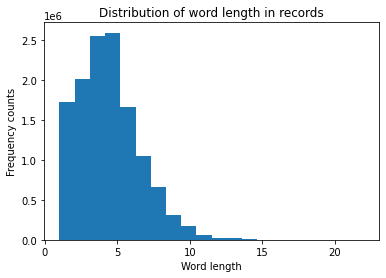

In [16]:
# INSERT HERE histogram 
plt.figure()
plt.hist(datadf['sf_length'],bins=20)
plt.title("Distribution of word length in records")
plt.xlabel("Word length")
plt.ylabel("Frequency counts")
plt.show()

Word lengths of around 4-5 are most commonly being learned. The distribution is slightly skewed to the right. 



A box plot of surface length vs p_forgot_bin is below:

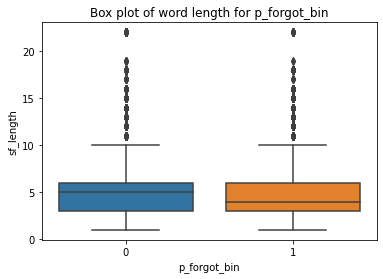

In [17]:
plt.figure()
sns.boxplot(x = 'p_forgot_bin',y='sf_length',data = datadf)
plt.xlabel("p_forgot_bin")
plt.ylabel("sf_length")
plt.title("Box plot of word length for p_forgot_bin")
plt.show()

The box plot above suggests that the mean value of word length for forgotten words is lower than the mean value for remembered words. 

A more granular look at the data is plotted by binning the word length, and computing the fraction of records with forgotten words for each interval. 

The function to do this is defined below:

In [18]:
def binnedx_meany(df,colx,coly,numbins,unit_x = '',annotate_counts = True,cut_type='n'):
  """
  Takes a dataframe with x = continuous, y = binary and calculates fraction of 1 in binary for different intervals of col x
  Plots a graph, annotates with counts in each bin. 
  Input:
  df: pandas dataframe
  colx: continuous column, x axis in plot, (string)
  unit_x: unit to add in plot for colx, (string, default = '')
  coly: binary column, y axis in plot, (string)
  numbins : number of bins to use while binning continuous column (int)
  annotate_counts: whether or not to annotate the line plot with the 
                    number of values used to compute mean values. (bool, default=True)
  cut_type: constant intervals, or quantile cuts
  
  Output:
  meany_colx: pandas dataframe with the mean values of y for each bin in x, and the count of each bin. 
  a plot is also drawn.
  """

  # binning values of continuous x column
  if cut_type=='n':
    df['binned_'+colx] = pd.cut(df[colx],bins=numbins)
  else:
    df['binned_'+colx] = pd.qcut(df[colx],q=numbins,duplicates='drop')

  # for each bin of delta, gettin the percentage of records with words forgotten
  meany_colx = df.groupby('binned_'+colx).agg(fraction_y = (coly,'mean'), totalcount = (coly,'count'))
  meany_colx = meany_colx.reset_index()

  # getting the middle value of each bin interval
  meany_colx['binned_'+colx+'_mid'] = meany_colx['binned_'+colx].apply(lambda x: x.mid)

  # plotting mid of interval and percentage of words forgotten within that interval
  plt.figure(figsize=(11,5))
  plt.plot(meany_colx['binned_'+colx+'_mid'],meany_colx['fraction_y'],'.-')
  plt.xlabel(f"{colx} {unit_x}")
  plt.ylabel(f"Fraction of records where {coly} == 1")
  plt.title(f"Frequency of {coly} = 1 vs {colx} {unit_x}")
  if annotate_counts:
    for ind in meany_colx.index:
      plt.annotate(s = f"{meany_colx.loc[ind,'totalcount']}",\
                  xy = (meany_colx.loc[ind,'binned_'+colx+'_mid'],\
                        meany_colx.loc[ind,'fraction_y']))
  plt.show()

  return meany_colx


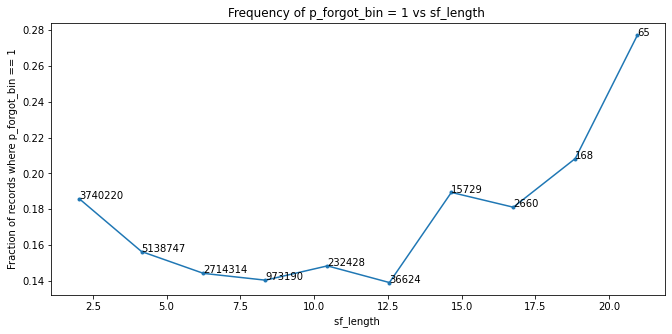

,binned_sf_length,fraction_y,totalcount,binned_sf_length_mid
0,"(0.979, 3.1]",0.185926,3740220,2.0395
1,"(3.1, 5.2]",0.156496,5138747,4.1500
2,"(5.2, 7.3]",0.144327,2714314,6.2500
3,"(7.3, 9.4]",0.140545,973190,8.3500
4,"(9.4, 11.5]",0.148515,232428,10.4500
5,"(11.5, 13.6]",0.139226,36624,12.5500
6,"(13.6, 15.7]",0.189459,15729,14.6500
7,"(15.7, 17.8]",0.181203,2660,16.7500
8,"(17.8, 19.9]",0.208333,168,18.8500
9,"(19.9, 22.0]",0.276923,65,20.9500


In [19]:
binnedx_meany(datadf,colx='sf_length',coly = 'p_forgot_bin',numbins=10,unit_x = '',annotate_counts = True)

Each point on the plot is the fraction of records with forgotten words plotted against the midpoint of each interval. The annotation is the number of records from which the fraction is calculated. 

The plot above shows an interesting non-linear relationship between word length and fraction of forgotten words. It seems that words are forgotten less with increasing word length up to about 12, and then rises sharply.

Another observation to note is that the number of records decreases with increasing length, possibly because shorter words are taught in earlier lessons, and few students make it to advanced lessons with longer words. 

Following that logic, shorter words may have a higher fraction of forgetting than the mid length words, simply because there is a higher representation of new learners who are testing the software and not necessarily committed, leading to more forgotten words. 

Word based features and student based features may be confounding variables. This is tested out quickly by looking at the curves of binned word length and fraction of forgetting for three different students.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


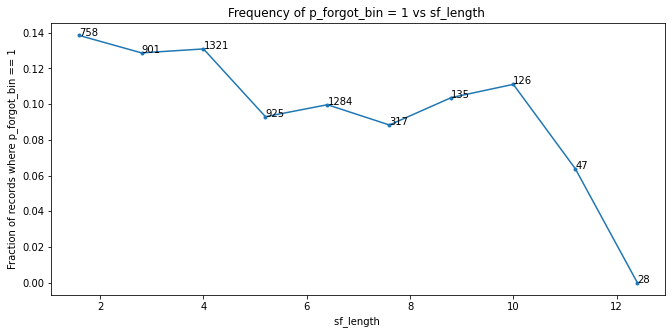

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


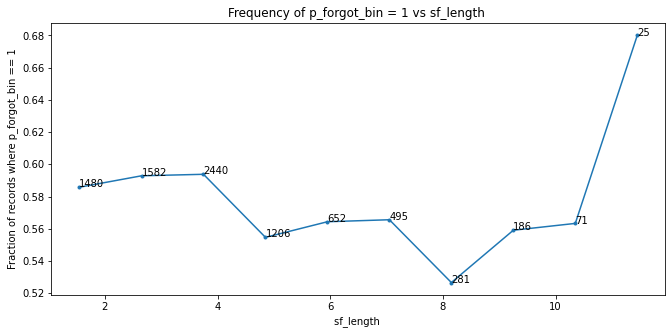

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


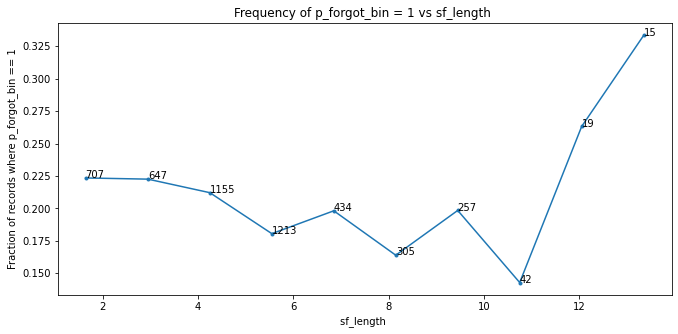

,binned_sf_length,fraction_y,totalcount,binned_sf_length_mid
0,"(0.987, 2.3]",0.223479,707,1.6435
1,"(2.3, 3.6]",0.222566,647,2.9500
2,"(3.6, 4.9]",0.212121,1155,4.2500
3,"(4.9, 6.2]",0.180544,1213,5.5500
4,"(6.2, 7.5]",0.198157,434,6.8500
5,"(7.5, 8.8]",0.163934,305,8.1500
6,"(8.8, 10.1]",0.198444,257,9.4500
7,"(10.1, 11.4]",0.142857,42,10.7500
8,"(11.4, 12.7]",0.263158,19,12.0500
9,"(12.7, 14.0]",0.333333,15,13.3500


In [20]:
#u:bqSO (5842)
# INSERT HERE - tiltes for each user and the number of records. also see if you can add to the same graph. 
binnedx_meany(datadf.loc[datadf['user_id']=='u:bqSO'],colx='sf_length',coly = 'p_forgot_bin',numbins=10,unit_x = '',annotate_counts = True)
#u:IY_ (8418)
binnedx_meany(datadf.loc[datadf['user_id']=='u:IY_'],colx='sf_length',coly = 'p_forgot_bin',numbins=10,unit_x = '',annotate_counts = True)
# u:gOYJ (4794)
binnedx_meany(datadf.loc[datadf['user_id']=='u:gOYJ'],colx='sf_length',coly = 'p_forgot_bin',numbins=10,unit_x = '',annotate_counts = True)

In the above three graphs, the first student differs from the other two in performance of longer words, they start of at a fairly low fraction of forgetting for shorter words compared to the others, and their performance with longer words (possibly occuring more often in the advanced lessons) gets better, indicating dedicating studying. The other two students have higher forgetting fractions at shorter words, and perform poorly with longer words. 

## <font color='cornflowerblue' size=3>Is similarity of a word with its native language meaning related to the probability of forgetting the word?</font>

Consider the word 'carta' in Spanish which means 'playing cards' in English. The words 'carta' and 'cards' are similar; would an English speaker learning Spanish find this word easier to remember than a word with no English meaning that shared any syllables?

To test this, we downloaded translations using the Google Translate API in [this notebook](https://colab.research.google.com/drive/1fLSMZpBhu-WIAnBQ7-sV-2fVx3r0or9f#scrollTo=baHfPsJBTnUd)

INSERT HERE: include environment variables for installing, and get the installation out of the jupyter notebook. 

Load the translation dictionaries from drive and decompress.

In [21]:
fr_to_en_sfdict = decompress_pickle(path_name+"Frenchtoenglish_sf.pbz2")
fr_to_en_lfdict = decompress_pickle(path_name+"Frenchtoenglish_lf.pbz2")

In [22]:
es_to_en_sfdict = decompress_pickle(path_name+"Spanishtoenglish_sf.pbz2")
es_to_en_lfdict = decompress_pickle(path_name+"Spanishtoenglish_lf.pbz2")

it_to_en_sfdict = decompress_pickle(path_name+"Italiantoenglish_sf.pbz2")
it_to_en_lfdict = decompress_pickle(path_name+"Italiantoenglish_lf.pbz2")

de_to_en_sfdict = decompress_pickle(path_name+"Germantoenglish_sf.pbz2")
de_to_en_lfdict = decompress_pickle(path_name+"Germantoenglish_lf.pbz2")
 
pt_to_en_sfdict = decompress_pickle(path_name+"Portuguesetoenglish_sf.pbz2")
pt_to_en_lfdict = decompress_pickle(path_name+"Portuguesetoenglish_lf.pbz2")

en_to_es_sfdict = decompress_pickle(path_name+"Englishtospanish_sf.pbz2")
en_to_es_lfdict = decompress_pickle(path_name+"Englishtospanish_lf.pbz2")

en_to_it_sfdict = decompress_pickle(path_name+"Englishtoitalian_sf.pbz2")
en_to_it_lfdict = decompress_pickle(path_name+"Englishtospanish_lf.pbz2")

en_to_pt_sfdict = decompress_pickle(path_name+"Englishtoportuguese_sf.pbz2")
en_to_pt_lfdict = decompress_pickle(path_name+"Englishtoportuguese_lf.pbz2")

Add all translations to the all_lexemes dataframe:

In [23]:
all_lexemes['sf_translation'] = ''
all_lexemes['lf_translation'] = ''
all_lexemes.loc[(all_lexemes['learning_language']=='fr') ,'sf_translation'] = all_lexemes['surface_form'].map(fr_to_en_sfdict)
all_lexemes.loc[(all_lexemes['learning_language']=='fr') ,'lf_translation'] = all_lexemes['lemma_form'].map(fr_to_en_lfdict)

all_lexemes.loc[(all_lexemes['learning_language']=='es'), 'sf_translation'] = all_lexemes['surface_form'].map(es_to_en_sfdict)
all_lexemes.loc[(all_lexemes['learning_language']=='es'), 'lf_translation'] = all_lexemes['lemma_form'].map(es_to_en_lfdict)

all_lexemes.loc[(all_lexemes['learning_language']=='it'), 'sf_translation'] = all_lexemes['surface_form'].map(it_to_en_sfdict)
all_lexemes.loc[(all_lexemes['learning_language']=='it'), 'lf_translation'] = all_lexemes['lemma_form'].map(it_to_en_lfdict)

all_lexemes.loc[(all_lexemes['learning_language']=='de'),'sf_translation'] = all_lexemes['surface_form'].map(de_to_en_sfdict)
all_lexemes.loc[(all_lexemes['learning_language']=='de'),'lf_translation'] = all_lexemes['lemma_form'].map(de_to_en_lfdict)

all_lexemes.loc[(all_lexemes['learning_language']=='pt'),'sf_translation'] = all_lexemes['surface_form'].map(pt_to_en_sfdict)
all_lexemes.loc[(all_lexemes['learning_language']=='pt'),'lf_translation'] = all_lexemes['lemma_form'].map(pt_to_en_lfdict)

all_lexemes.loc[(all_lexemes['learning_language']=='en'),'sf_translation'] = all_lexemes['surface_form'].map(en_to_es_sfdict)
all_lexemes.loc[(all_lexemes['learning_language']=='en'),'lf_translation'] = all_lexemes['lemma_form'].map(en_to_es_lfdict)

all_lexemes.loc[(all_lexemes['learning_language']=='en'),'sf_translation'] = all_lexemes['surface_form'].map(en_to_it_sfdict)
all_lexemes.loc[(all_lexemes['learning_language']=='en'),'lf_translation'] = all_lexemes['lemma_form'].map(en_to_it_lfdict)

all_lexemes.loc[(all_lexemes['learning_language']=='en'),'sf_translation'] = all_lexemes['surface_form'].map(en_to_pt_sfdict)
all_lexemes.loc[(all_lexemes['learning_language']=='en'),'lf_translation'] = all_lexemes['lemma_form'].map(en_to_pt_lfdict)


Checking for null values:

In [24]:
all_lexemes['sf_translation'].isna().sum()

633

Out of 12679 words, 633 words are not translated. The missing values will be dealt with in their numeric representations later. 

Listing some of the missing translation words:

In [25]:
all_lexemes.loc[all_lexemes['sf_translation'].isna(),['surface_form','sf_translation']].head(5)

,surface_form,sf_translation
3740116,choisi,NaN
3740477,grâce,NaN
3743509,plante,NaN
3745291,faisons,NaN
3745924,nul,NaN


There is nothing strange about the surface form of the word itself. 

In [26]:
all_lexemes.loc[all_lexemes['sf_translation']==''].shape[0], all_lexemes.loc[all_lexemes['lf_translation']==''].shape[0] 

(0, 0)

Displaying some of the translations:

In [27]:
all_lexemes.head()

,lexeme_id,learning_language,lexeme_string,surface_form,lemma_form,pos,modstrings,sf_length,sf_translation,lf_translation
0,76390c1350a8dac31186187e2fe1e178,de,lernt/lernen<vblex><pri><p3><sg>,lernt,lernen,vblex,"[pri, p3, sg]",5,learns,to learn
1,7dfd7086f3671685e2cf1c1da72796d7,de,die/die<det><def><f><sg><nom>,die,die,det,"[def, f, sg, nom]",3,the,the
2,35a54c25a2cda8127343f6a82e6f6b7d,de,mann/mann<n><m><sg><nom>,mann,mann,n,"[m, sg, nom]",4,husband,husband
3,0cf63ffe3dda158bc3dbd55682b355ae,de,frau/frau<n><f><sg><nom>,frau,frau,n,"[f, sg, nom]",4,Mrs,Mrs
4,84920990d78044db53c1b012f5bf9ab5,de,das/das<det><def><nt><sg><nom>,das,das,det,"[def, nt, sg, nom]",3,the,the


### <font color='cornflowerblue' size=3>Levenshtein distance computation</font>

Now the Levenshtein string distances are calculated for words and their meanings in the native language. 

**Reasoning:**
For instance, the Levenshtein distance between 'lernt', a German word, and its meaning 'learns' in English, is 2, whereas the word 'mann' in German meaning 'husband' in English has a Levenshtein distance of 5. The hypothesis is that lower Levenshtein distances means that the learner will be able to remember the word more easily.   

Installing and importing library

In [28]:
#https://pypi.org/project/python-Levenshtein/
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import Levenshtein

In [30]:
Levenshtein.distance("parís", "paris"), Levenshtein.distance("learns", "to learn"), Levenshtein.distance("mann", "husband")

(1, 4, 5)

Will need to tweak the distance to reflect that 'í' is almost like 'i'.

In Spanish, the grapheme ñ is considered a new letter different from n and collated between n and o, as it denotes a different sound from that of a plain n. But the accented vowels á, é, í, ó, ú are not separated from the unaccented vowels a, e, i, o, u, as the acute accent in Spanish only modifies stress within the word or denotes a distinction between homonyms, and does not modify the sound of a letter.

We can replace the special characters with the regular ones.

In [31]:
# stripping accents
all_lexemes['surface_form_no_accents'] = all_lexemes['surface_form'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
all_lexemes['lemma_form_no_accents'] = all_lexemes['lemma_form'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
# https://www.codegrepper.com/code-examples/typescript/remove+accents+python+pandas

In [32]:
all_lexemes[['surface_form_no_accents','surface_form']].head()

,surface_form_no_accents,surface_form
0,lernt,lernt
1,die,die
2,mann,mann
3,frau,frau
4,das,das


A function is defined to get the Levenshtein string distance between the closest meaning word and the word being learned. 

In [33]:
def get_abs_L_distance(word_orig,meaning): # parse out words from meaning, get max JW similarity. also save number of words for confidence level
  #word = replace_accents(word_orig).lower() # what if it is a two-word or hyphenated?
  word = word_orig.lower()
  #meaning = replace_accents(meaning)
  #print('replaced: ',word,'\n',meaning)
  meaning_split = ''.join([ch.lower() for ch in meaning if (ch.isalpha() or ch==' ' or ch=='\n') or ch=='-']).split() # parsing out word tokens and getting rid of special characters and punctuation marks
  #print('split meaning:',meaning_split)
  distances = [Levenshtein.distance(meaning_w,word) for meaning_w in meaning_split]
  #print('distances:',distances)
  try:
    min_distance = min(distances)
    min_word = meaning_split[distances.index(min_distance)]
  except:
    min_distance = 10000
    min_word = ''
  return (min_distance,min_word)

In [34]:
get_abs_L_distance('lernt','learns')

(2, 'learns')

In [35]:
all_lexemes['sf_translation'] = all_lexemes['sf_translation'].astype(str)
all_lexemes['L_dist_word_tup_sf_noaccents'] = all_lexemes[['surface_form_no_accents','sf_translation']].apply(lambda x: get_abs_L_distance(x[0],x[1]),axis=1)
all_lexemes['L_dist_sf_noaccents'] = all_lexemes['L_dist_word_tup_sf_noaccents'].apply(lambda x:x[0])
all_lexemes['L_dist_sf_noaccents_norm'] = all_lexemes['L_dist_sf_noaccents']/all_lexemes['sf_length']

In [36]:
all_lexemes[['surface_form_no_accents','sf_translation','L_dist_sf_noaccents','L_dist_sf_noaccents_norm']].head(10)

,surface_form_no_accents,sf_translation,L_dist_sf_noaccents,L_dist_sf_noaccents_norm
0,lernt,learns,2,0.400000
1,die,the,2,0.666667
2,mann,husband,5,1.250000
3,frau,Mrs,3,0.750000
4,das,the,3,1.000000
5,der,the,3,1.000000
6,kind,child,3,0.750000
7,bajo,bass,2,0.500000
18,madchen,girl,7,1.000000
19,apfel,Apple,3,0.600000


In [37]:
datadf['L_dist_sf_noaccents_norm'] = datadf['lexeme_id'].map(dict(zip(all_lexemes['lexeme_id'],all_lexemes['L_dist_sf_noaccents_norm'])))

In [38]:
datadf['L_dist_sf_noaccents_norm'].describe()

count    1.285414e+07
mean     9.143399e+00
std      2.780306e+02
min      0.000000e+00
25%      6.666667e-01
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+04
Name: L_dist_sf_noaccents_norm, dtype: float64

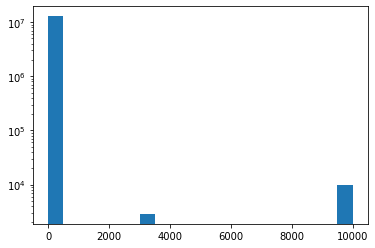

In [39]:
plt.hist(datadf['L_dist_sf_noaccents_norm'],bins=20,log=True)
plt.show()

There are some strange outliers in the normalized Levenshtein value, which one would expect to be around 0 to 5 at most. 

Filtering to values over 10:

In [40]:
all_lexemes.loc[all_lexemes['L_dist_sf_noaccents_norm']>10,['surface_form_no_accents','sf_translation','L_dist_sf_noaccents','L_dist_sf_noaccents_norm']]

,surface_form_no_accents,sf_translation,L_dist_sf_noaccents,L_dist_sf_noaccents_norm
277,',&#39;,10000,10000.000000
4558,one,1,10000,3333.333333
56420,one,1,10000,3333.333333


Since there are only 3 such records, they are changed manually

In [41]:
all_lexemes.loc[all_lexemes['surface_form_no_accents']=="'",'sf_translation']="'"
all_lexemes.loc[all_lexemes['surface_form_no_accents']=="one",'sf_translation']="one"

In [42]:
all_lexemes['sf_translation'] = all_lexemes['sf_translation'].astype(str)
all_lexemes['L_dist_word_tup_sf_noaccents'] = all_lexemes[['surface_form_no_accents','sf_translation']].apply(lambda x: get_abs_L_distance(x[0],x[1]),axis=1)
all_lexemes['L_dist_sf_noaccents'] = all_lexemes['L_dist_word_tup_sf_noaccents'].apply(lambda x:x[0])
all_lexemes['L_dist_sf_noaccents_norm'] = all_lexemes['L_dist_sf_noaccents']/all_lexemes['sf_length']

In [43]:
all_lexemes[['surface_form_no_accents','sf_translation','L_dist_sf_noaccents','L_dist_sf_noaccents_norm']].head(10)

,surface_form_no_accents,sf_translation,L_dist_sf_noaccents,L_dist_sf_noaccents_norm
0,lernt,learns,2,0.400000
1,die,the,2,0.666667
2,mann,husband,5,1.250000
3,frau,Mrs,3,0.750000
4,das,the,3,1.000000
5,der,the,3,1.000000
6,kind,child,3,0.750000
7,bajo,bass,2,0.500000
18,madchen,girl,7,1.000000
19,apfel,Apple,3,0.600000


In [44]:
datadf['L_dist_sf_noaccents_norm'] = datadf['lexeme_id'].map(dict(zip(all_lexemes['lexeme_id'],all_lexemes['L_dist_sf_noaccents_norm'])))

In [45]:
datadf['L_dist_sf_noaccents_norm'].describe()

count    1.285414e+07
mean     8.401226e+00
std      2.735692e+02
min      0.000000e+00
25%      6.666667e-01
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+04
Name: L_dist_sf_noaccents_norm, dtype: float64

In [46]:
all_lexemes.loc[all_lexemes['L_dist_sf_noaccents_norm']>10,['surface_form_no_accents','sf_translation','L_dist_sf_noaccents','L_dist_sf_noaccents_norm']]

,surface_form_no_accents,sf_translation,L_dist_sf_noaccents,L_dist_sf_noaccents_norm
277,',',10000,10000.0


In [47]:
all_lexemes.loc[all_lexemes['L_dist_sf_noaccents_norm']>10,'L_dist_sf_noaccents'] = 0
all_lexemes.loc[all_lexemes['L_dist_sf_noaccents_norm']>10,'L_dist_sf_noaccents_norm'] = 0

In [48]:
all_lexemes.loc[all_lexemes['L_dist_sf_noaccents_norm']>10,['surface_form_no_accents','sf_translation','L_dist_sf_noaccents','L_dist_sf_noaccents_norm']]

,surface_form_no_accents,sf_translation,L_dist_sf_noaccents,L_dist_sf_noaccents_norm


In [49]:
datadf['L_dist_sf_noaccents_norm'] = datadf['lexeme_id'].map(dict(zip(all_lexemes['lexeme_id'],all_lexemes['L_dist_sf_noaccents_norm'])))

Since missing values have now been dealt with, distribution of normalized Levenshtein distance are plotted for both groups: forgotten and remembered words. 

In [50]:
datadf.loc[datadf['p_forgot_bin']==0,'L_dist_sf_noaccents_norm'].mean(), datadf.loc[datadf['p_forgot_bin']==1,'L_dist_sf_noaccents_norm'].mean()

(0.904455075460555, 0.9404605833569791)

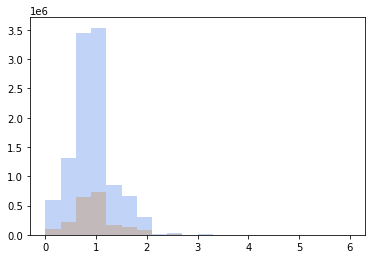

In [51]:
plt.hist(datadf.loc[datadf['p_forgot_bin']==1,'L_dist_sf_noaccents_norm'],bins=20,label = 'forgotten words',alpha=0.4,color='darkorange')
plt.hist(datadf.loc[datadf['p_forgot_bin']==0,'L_dist_sf_noaccents_norm'],bins=20,label = 'remembered words',alpha=0.4,color='cornflowerblue')
plt.show()

Levenshtein distance to meaning words is fairly normally distributed for both groups, with a mean of 0.90 for remembered words, and a mean of 0.94 for forgotten words.

A box plot of Levenshtein distance normalized for forgotten and remembered words is below:



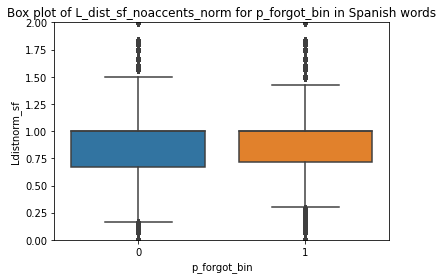

In [52]:
plt.figure()
sns.boxplot(x = 'p_forgot_bin',y='L_dist_sf_noaccents_norm',data = datadf)
plt.xlabel("p_forgot_bin")
plt.ylabel("Ldistnorm_sf")
plt.ylim((0,2))
plt.title("Box plot of L_dist_sf_noaccents_norm for p_forgot_bin in Spanish words")
plt.show()

A one-way ANOVA test is performed below to see if the null hypothesis thaat the two groups have the same mean normalized Levenshtein distance can be rejected:

In [53]:
# one -way anova function defined below:
def one_way_anova_summary(cat_v, num_v, df, exclude = []):
  """
  Gives a summary of one-way ANOVA test results for a categorical and numerical variable in a pandas dataframe,
  including hypotheses, values, and a boxplot. 
  ===========================================
  Requires libraries: 

  matplotlib.pyplot as plt
  seaborn as sns
  stats from scipy
  pandas as pd
  ===========================================
  Arguments:

  cat_v: categorical variable name in dataframe, string type
  num_v: numerical variable name in dataframe, string type
  df: dataframe of interest
  exclude : categorical values to exclude, list type, default is empty list
  ===========================================
  Returns:
  statval: test statistic value for one-way ANOVA test
  pval: p-value for one-way ANOVA test with categorical and numerical variable in dataframe
  pltobj : matplotlib plot object showing a boxplot of the groups
  ============================================
  """
  assert type(cat_v)==str, "Categorical variable name has to be a string"
  assert cat_v in df.columns, "Categorical variable not found in dataframe"
  assert type(num_v)==str, "Numerical variable name has to be a string"
  assert num_v in df.columns, "Numerical variable not found in dataframe"
  assert type(exclude)==list, "Exclude argument has to be a list"
  
  catv_anova = dict()
  catv_vals = df[cat_v].unique()


  for val in catv_vals:
    if val not in exclude:
      catv_anova[val] = df.loc[df[cat_v]==val,num_v]
  
  catv_args = tuple([item[1] for item in catv_anova.items()])

  statval,pval = stats.f_oneway(*catv_args)

  print(f"{cat_v} & {num_v} one-way ANOVA Test:")
  print("="*30)
  print()
  print("Groups tested:")
  print("="*30)
  print(list(catv_anova.keys()))
  print()
  print(f"Null hypothesis H0: The mean value of {num_v} is the same across the groups in {cat_v}")
  print(f"Alternate hypothesis Ha: The mean value of {num_v} is different for at least one group in {cat_v}")
  print("="*30)
  print()
  print(f"{cat_v} & {num_v} one-way ANOVA Results:")
  print(f"test_statistic = {statval}, p-value = {pval}")
  print()

  if pval<0.05:
    print(f"Based on the p-value of {pval}, we can reject the null hypothesis that the mean {num_v} is the same for all groups.")
    print(f"At least one group in {cat_v} has a different mean value of {num_v}")
  else:
    print(f"Based on the p-value of {pval}, we cannot reject the null hypothesis that the mean {num_v} is the same for all groups.")

  
  # pltobj = sns.boxplot(x=num_v, y=cat_v, data=df.loc[~df[cat_v].isin(exclude)])
  # try:
  #   pltobj.title(num_v+" by "+cat_v)
  # except:
  #   pltobj.set_title(num_v+" by "+cat_v) 

  
  return statval,pval#,pltobj

In [54]:
from scipy import stats
one_way_anova_summary('p_forgot_bin','L_dist_sf_noaccents_norm', datadf, exclude = [])

p_forgot_bin & L_dist_sf_noaccents_norm one-way ANOVA Test:

Groups tested:
[0, 1]

Null hypothesis H0: The mean value of L_dist_sf_noaccents_norm is the same across the groups in p_forgot_bin
Alternate hypothesis Ha: The mean value of L_dist_sf_noaccents_norm is different for at least one group in p_forgot_bin

p_forgot_bin & L_dist_sf_noaccents_norm one-way ANOVA Results:
test_statistic = 12817.317792838357, p-value = 0.0

Based on the p-value of 0.0, we can reject the null hypothesis that the mean L_dist_sf_noaccents_norm is the same for all groups.
At least one group in p_forgot_bin has a different mean value of L_dist_sf_noaccents_norm


(12817.317792838357, 0.0)

Since the p-value << 0.05, the null hypothesis that the mean normalized Levenshtein distance is the same for forgotten and remembered words can be rejected. 

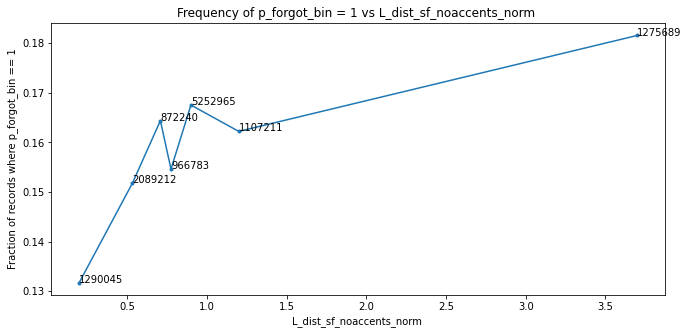

,binned_L_dist_sf_noaccents_norm,fraction_y,totalcount,binned_L_dist_sf_noaccents_norm_mid
0,"(-0.001, 0.4]",0.131777,1290045,0.1995
1,"(0.4, 0.667]",0.151820,2089212,0.5335
2,"(0.667, 0.75]",0.164377,872240,0.7085
3,"(0.75, 0.8]",0.154623,966783,0.7750
4,"(0.8, 1.0]",0.167525,5252965,0.9000
5,"(1.0, 1.4]",0.162222,1107211,1.2000
6,"(1.4, 6.0]",0.181543,1275689,3.7000


In [55]:
binnedx_meany(datadf,colx='L_dist_sf_noaccents_norm',coly = 'p_forgot_bin',numbins=10,unit_x = '',annotate_counts = True,cut_type='q')

Overall, words with lower Levenshtein distance (similar to their native language meanings) are forgotten less frequently, while words that are very different from the native meanings are forgotten more frequently. There is a somewhat upward trend in the fraction of records with forgotten words with increasing string distance.

## <font color = 'cornflowerblue' size=3>Is the inverse-document-frequency of a word related to the ease of remembering it?</font>

Inverse document frequency is the reciprocal of the number of documents a word occurs in, based on a certain corpus. 

The hypothesis is that words that are commonly used, such as 'cat' or 'dog' are more likely to be remembered by a foreign speaker of English than words that occur relatively rarely, such as 'harpoon'. 

One assumption made is that words that occur rarely in English represent concepts that occur rarely in the native languages as well, and are therfore cued in memory less often. This is a broad assumption, and may well not be justified, as one might expect cultural differences to impact frequency of words occuring in literature. 

Approach to getting the IDF values:

1. For languages other than English, their English translations have already been obtained (using the Google Cloud translate API) in this [notebook](https://colab.research.google.com/drive/1fLSMZpBhu-WIAnBQ7-sV-2fVx3r0or9f#scrollTo=gBFw4sN8shrA)

2. British National corpus consisting of INSERT HERE on various subjects is mined to compute the IDFs of 1-grams in [this notebook](https://github.com/rts1988/IntelligentTutoringSystem_Experiments/blob/master/concept_extraction/Build_IDF_dictionary.ipynb).

3. IDF values are obtained for English translations where the learning language is not English. As a first pass assumption, in the case of meanings with more than one word, the maximum IDF will be used, since rareness is what needs to be quantified. 

2. Correlation between word length and IDF will be checked. 

3. Relationship with forgetting a word is visualized

Downloading the IDF dictionary file. 

In [56]:
BNCIDF_df = pd.read_csv(path_name+'BNC_IDFdictlite.csv')
BNCIDF_df1 = BNCIDF_df.groupby('lemma')['IDF'].min()
BNCIDF_dict = BNCIDF_df1.to_dict()

In [57]:
BNCIDF_dict['husband'], BNCIDF_dict['my'], BNCIDF_dict['harpoon']

(1.258263043, 0.3367159045, 7.123942992)

For language courses where the learning language is not English, the IDF will be obtained from the English meaning words. 

In [58]:
# for learning language not english, the 'IDF word' column is set to the English meaning 
all_lexemes.loc[all_lexemes['learning_language']!='en','IDFword'] = all_lexemes.loc[all_lexemes['learning_language']!='en','sf_translation']
# for learning language == english, the 'IDF word' column is set to the English surface form
all_lexemes.loc[all_lexemes['learning_language']=='en','IDFword'] = all_lexemes.loc[all_lexemes['learning_language']=='en','surface_form']

Checking for null values:

In [59]:
all_lexemes['IDFword'].isna().sum()

0

Defining function to handle multiple word and special character strings:

In [60]:
import re
def get_IDF(english_string):  
  splitstring = re.split(";|,|\-|\n|\s+|\-|\'",english_string.lower())
  IDF = max(BNCIDF_dict.get(w,float('nan')) for w in splitstring)
  return IDF


In [61]:
# adding IDF dictionary.
all_lexemes['EnglishIDF'] = all_lexemes['IDFword'].apply(lambda x:get_IDF(x))

Checking how many words were not in the BNC IDF dictionary:

In [62]:
all_lexemes['EnglishIDF'].isna().sum()

6778

There are 6777 words that were not in the IDF dictionary. The surface forms of these words are listed below

In [63]:
all_lexemes.loc[all_lexemes['EnglishIDF'].isna(),['surface_form','sf_translation']].value_counts()

surface_form  sf_translation
<*sf>         &lt;*sf&gt;       4495
              &lt;* sf&gt;      1100
kosten        costs                5
l'            I&#39;               5
elefanten     elephants            4
                                ... 
expériences   nan                  1
facteurs      nan                  1
factores      factors              1
faisait       nan                  1
übungen       nan                  1
Length: 1099, dtype: int64

The IDFhword for these is changed to the lemma form translation:

In [64]:
# for english words with nan IDF value, look for the lemma form
all_lexemes.loc[(all_lexemes['EnglishIDF'].isna()) & (all_lexemes['learning_language']=='en'),'IDFword'] = all_lexemes.loc[(all_lexemes['EnglishIDF'].isna()) & (all_lexemes['learning_language']=='en'),'lemma_form'].astype(str)
# for non english words with nan IDF value, look for the lemma form translation
all_lexemes.loc[(all_lexemes['EnglishIDF'].isna()) & (all_lexemes['learning_language']!='en'),'IDFword'] = all_lexemes.loc[(all_lexemes['EnglishIDF'].isna()) & (all_lexemes['learning_language']!='en'),'lf_translation'].astype(str)

Calculating IDF values again

In [65]:
all_lexemes['EnglishIDF'] = all_lexemes['IDFword'].apply(lambda x:get_IDF(x))

In [66]:
all_lexemes['EnglishIDF'].isna().sum()

576

Now there are 576 values that are missing. Listing them below:

In [67]:
all_lexemes.loc[all_lexemes['EnglishIDF'].isna(),['surface_form','sf_translation','lemma_form','lf_translation']].value_counts()

surface_form   sf_translation          lemma_form     lf_translation        
eltern         parents                 eltern         parents                   4
kosten         costs                   kosten         costs                     3
vrai           true                    vrai           true                      2
bitte          You&#39;re welcome      bitte          You&#39;re welcome        2
sorgt          cares                   sorgen         worries                   1
ländern        countries               länder         countries                 1
magari         let&#39;s hope          magari         let&#39;s hope            1
mitarbeiter    employees               mitarbeiter    employees                 1
münster        Muenster                münster        Muenster                  1
pantalones     pants                   pantalón       pants                     1
pantalón       pants                   pantalón       pants                     1
pants          calça 

Changing the get_IDF function to replace some of these special characters: &#39; and apostrophe, and getting lemma forms of the lf_translation from wordnet. 

The distribution of EnglishIDF is plotted for each learning language:

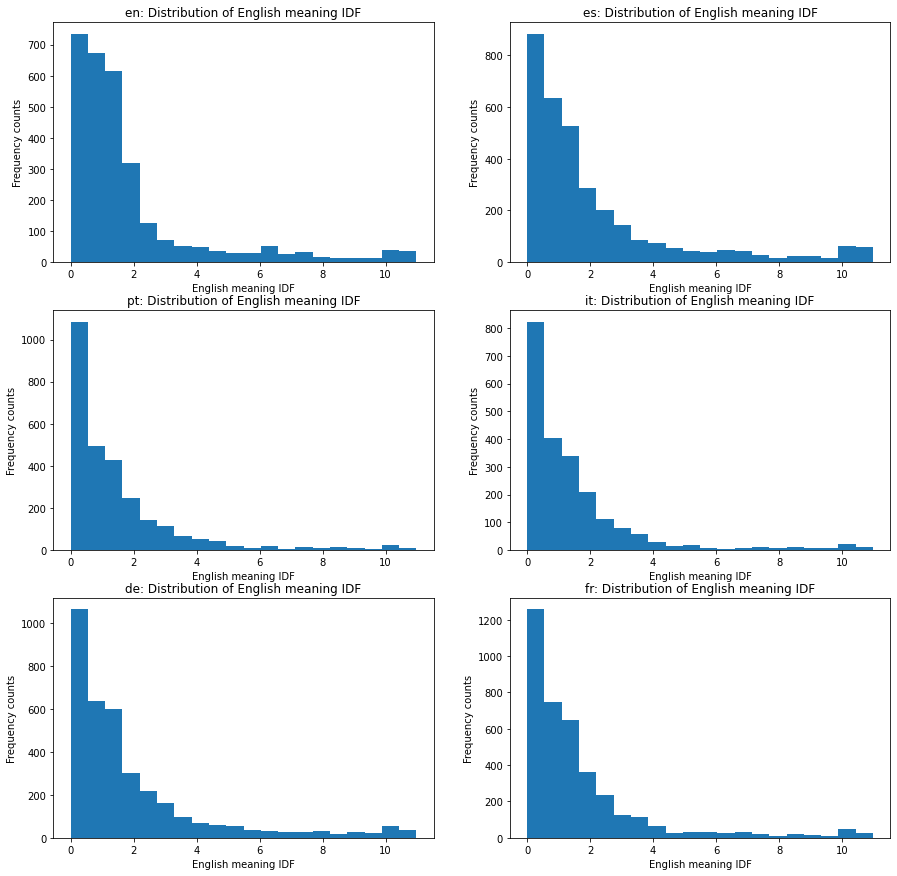

In [68]:
plt.subplots(3,2,figsize=(15,15))
plot_num = 1

for ll in ['en','es','pt','it','de','fr']:
  plt.subplot(3,2,plot_num)
  plt.title(f"{ll}: Distribution of English meaning IDF")
  plt.hist(all_lexemes.loc[all_lexemes['learning_language']==ll,'EnglishIDF'],bins=20)
  plt.xlabel("English meaning IDF")
  plt.ylabel("Frequency counts")
  plot_num +=1

plt.show()

It appears that the distribution of IDF in all 6 learning languages are somehwat similar. English and Spanish have higher mean English IDFs for the set of words being learned. The other languages have a lower mean. 

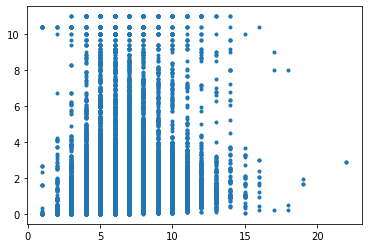

In [69]:
plt.plot(all_lexemes['sf_length'],all_lexemes['EnglishIDF'],'.')

In [70]:
datadf['EnglishIDF'] = datadf['lexeme_id'].map(dict(zip(all_lexemes['lexeme_id'],all_lexemes['EnglishIDF'])))

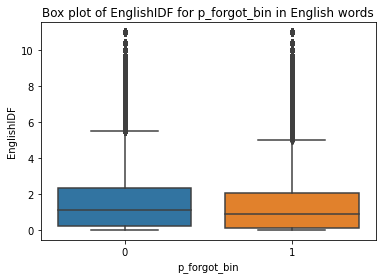

In [71]:
plt.figure()
sns.boxplot(x = 'p_forgot_bin',y='EnglishIDF',data = datadf)
plt.xlabel("p_forgot_bin")
plt.ylabel("EnglishIDF")
plt.title("Box plot of EnglishIDF for p_forgot_bin in English words")
plt.show()

There is a minor difference in the distributions of IDF for records with forgotten and remembered words. Forgotten words seem to have a somewhat lower IDF value, which goes against the hypothesis of rare words being harder to remember. 

Below is a line plot of the fraction of records with forgotten words for binned values of IDF:

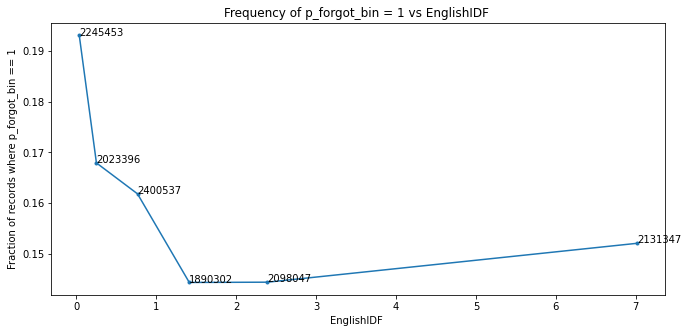

,binned_EnglishIDF,fraction_y,totalcount,binned_EnglishIDF_mid
0,"(-0.000643, 0.0739]",0.193084,2245453,0.036628
1,"(0.0739, 0.429]",0.167935,2023396,0.251450
2,"(0.429, 1.102]",0.161838,2400537,0.765500
3,"(1.102, 1.725]",0.144365,1890302,1.413500
4,"(1.725, 3.057]",0.144416,2098047,2.391000
5,"(3.057, 10.982]",0.152086,2131347,7.019500


In [72]:
binnedx_meany(datadf,colx='EnglishIDF',coly = 'p_forgot_bin',numbins=6,unit_x = '',annotate_counts = True,cut_type='q')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


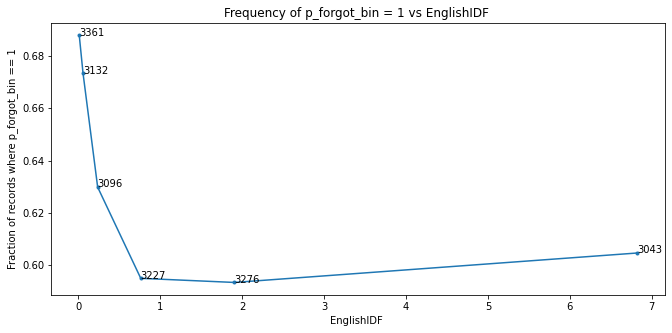

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


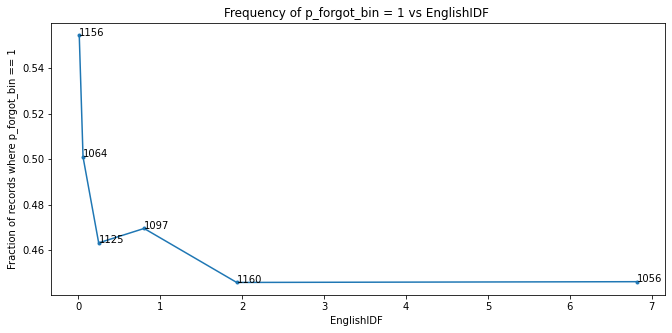

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


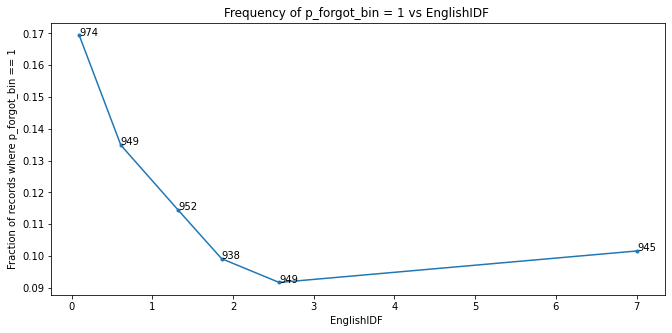

,binned_EnglishIDF,fraction_y,totalcount,binned_EnglishIDF_mid
0,"(6.999999999999997e-05, 0.192]",0.169405,974,0.096035
1,"(0.192, 1.03]",0.134879,949,0.611000
2,"(1.03, 1.609]",0.114496,952,1.319500
3,"(1.609, 2.11]",0.099147,938,1.859500
4,"(2.11, 3.034]",0.091675,949,2.572000
5,"(3.034, 10.982]",0.101587,945,7.008000


In [73]:
# INSERT HERE" add titles with user id, and comments
#u:bcH_
binnedx_meany(datadf.loc[datadf['user_id']=='u:bcH_'],colx='EnglishIDF',coly = 'p_forgot_bin',numbins=6,unit_x = '',annotate_counts = True,cut_type='q')
#u:NPs
binnedx_meany(datadf.loc[datadf['user_id']=='u:NPs'],colx='EnglishIDF',coly = 'p_forgot_bin',numbins=6,unit_x = '',annotate_counts = True,cut_type='q')
#u:ia1J
binnedx_meany(datadf.loc[datadf['user_id']=='u:ia1J'],colx='EnglishIDF',coly = 'p_forgot_bin',numbins=6,unit_x = '',annotate_counts = True,cut_type='q')

It should be noted that quantile cuts were used since the IDF value had a large number of words at very low numbers, and very few in the higher numbers. 
The line plot above indicates that a higher IDF is related to a lower probability of forgetting, which aligns with the box plot. 

INSERT HERE: one way ANOVA. or Kruskal walis, also distribution of IDF values. possible before the binned plot. 

### <font color='cornflowerblue' size=3>Checking correlations</font>

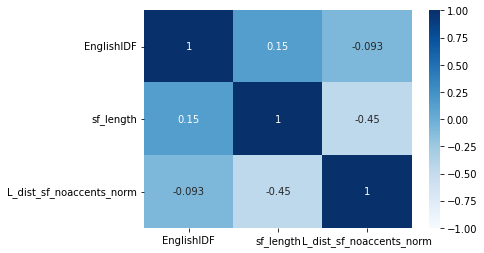

In [75]:
sns.heatmap(all_lexemes[['EnglishIDF','sf_length','L_dist_sf_noaccents_norm']].corr(),vmax=1,vmin=-1,annot=True,cmap= "Blues")

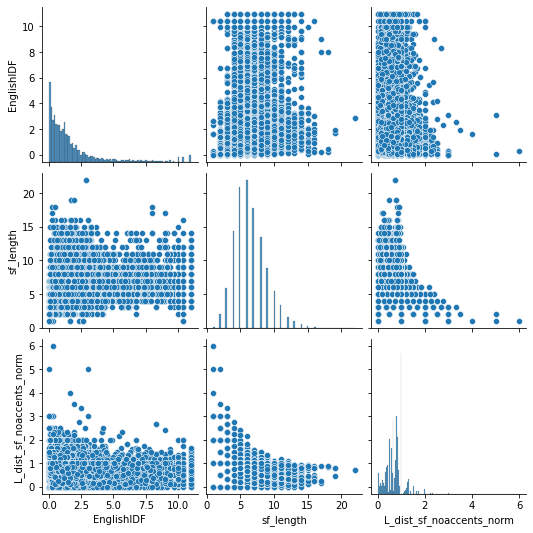

In [76]:
sns.pairplot(all_lexemes[['EnglishIDF','sf_length','L_dist_sf_noaccents_norm']])

## <font color = 'cornflowerblue' size=4>Storing word features in dataframe</font>

The following features were found useful, and will be stored along with each word.
1. word length
2. IDF for the english word (based on translations)
3. Levenshtein distance normalized to the surface form word length. 

## <font color='cornflowerblue' size= 3>Getting multilingual word vectors</font>

In [ ]:
word_vectors = "multilingual_embeddings.tar.gz"

Multilingual word vectors:
https://www.cs.cmu.edu/~afm/projects/multilingual_embeddings.html

did not use fasttext because it was taking too long to load (~15 min each language) and simply too big (4 GB each language)
https://github.com/babylonhealth/fastText_multilingual

In [253]:
# import gzip
# import shutil
# gzip.open(path_name+"multilingual_embeddings.tar.gz", 'rb')
#   with open("multilingual_embeddings.tar", 'wb') as f_out:
#     shutil.copyfileobj(f_in, f_out)

!tar -xvf /content/drive/MyDrive/multilingual_embeddings.tar.gz

#!tar -xvf  'file.tar' -C 'destination'

multilingual_embeddings.ar
multilingual_embeddings.de
multilingual_embeddings.en
multilingual_embeddings.es
multilingual_embeddings.fr
multilingual_embeddings.it
multilingual_embeddings.nl
multilingual_embeddings.pb
multilingual_embeddings.pl
multilingual_embeddings.ro
multilingual_embeddings.ru
multilingual_embeddings.tr


In [267]:
german_embeddings = dict()
with open('multilingual_embeddings.es','r') as f1:
  german_embeddings = f1.readlines()


In [274]:
#INSERT HERE figure out which one is potuguese. and see how many of these we actually have 

209300644

In [179]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')
#from fasttext import FastVector
#fr_dictionary = FastVector(vector_file='wiki.fr.vec')

KeyboardInterrupt: ignored

Getting dummies for each value in the modstrings list

In [183]:
# Download dan unzip model
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gunzip -k cc.en.300.bin.gz

# Install / Upgrade Gensim
!pip install --upgrade gensim

# Load model method 1 
from gensim.models.fasttext import FastText, load_facebook_vectors
model = load_facebook_vectors("cc.en.300.bin.gz")

--2022-06-30 14:52:27--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz      3%[                    ] 131.83M  2.51MB/s    eta 15m 56s^C

gzip: cc.en.300.bin.gz: unexpected end of file
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/exceptions.py", line 7, in <module>
    from pip._vendor.pkg_resources import Distribution
  File "/usr/local/lib/python3.7/

ImportError: ignored

In [ ]:
all_lexemes['modstrings'].explode()

7           NaN
20            m
20           pl
21          pri
21           p1
           ... 
12832145    ifi
12832145     p3
12832145     sg
12844305      f
12844305     sg
Name: modstrings, Length: 25498, dtype: object

In [ ]:
all_lexemes = pd.concat([all_lexemes,pd.get_dummies(all_lexemes['modstrings'].apply(pd.Series).stack(),prefix='mod').sum(level=0)],axis=1)
all_lexemes.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  """Entry point for launching an IPython kernel.


,lexeme_id,learning_language,lexeme_string,surface_form,lemma_form,pos,modstrings,sf_length,mod_*gndr,mod_*numb,...,mod_pron,mod_prs,mod_qnt,mod_ref,mod_sg,mod_sint,mod_sp,mod_subj,mod_sup,mod_tn
7,73eecb492ca758ddab5371cf7b5cca32,es,bajo/bajo<pr>,bajo,bajo,pr,[],4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,c84476c460737d9fb905dca3d35ec995,es,niños/niño<n><m><pl>,niños,niño,n,"[m, pl]",5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,1a913f2ded424985b9c02d0436008511,es,leo/leer<vblex><pri><p1><sg>,leo,leer,vblex,"[pri, p1, sg]",3,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
22,38b770e66595fea718366523b4f7db3f,es,libro/libro<n><m><sg>,libro,libro,n,"[m, sg]",5,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23,4bdb859f599fa07dd5eecdab0acc2d34,es,a/a<pr>,a,a,pr,[],1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
all_lexemes.fillna(0)

,lexeme_id,learning_language,lexeme_string,surface_form,lemma_form,pos,modstrings,sf_length,mod_*gndr,mod_*numb,...,mod_pron,mod_prs,mod_qnt,mod_ref,mod_sg,mod_sint,mod_sp,mod_subj,mod_sup,mod_tn
7,73eecb492ca758ddab5371cf7b5cca32,es,bajo/bajo<pr>,bajo,bajo,pr,[],4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,c84476c460737d9fb905dca3d35ec995,es,niños/niño<n><m><pl>,niños,niño,n,"[m, pl]",5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,1a913f2ded424985b9c02d0436008511,es,leo/leer<vblex><pri><p1><sg>,leo,leer,vblex,"[pri, p1, sg]",3,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
22,38b770e66595fea718366523b4f7db3f,es,libro/libro<n><m><sg>,libro,libro,n,"[m, sg]",5,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23,4bdb859f599fa07dd5eecdab0acc2d34,es,a/a<pr>,a,a,pr,[],1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12818467,822db15e4e056837f908d47692f6969e,pt,ajuda/ajudar<vblex><pri><p3><sg>,ajuda,ajudar,vblex,"[pri, p3, sg]",5,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12820313,aa25ea9dc156919749f444521720432c,fr,conférence/conférence<n><f><sg>,conférence,conférence,n,"[f, sg]",10,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12820316,3db97fbbdd0d4e08b8248b6219a86e4b,fr,liens/lien<n><m><pl>,liens,lien,n,"[m, pl]",5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12832145,8b53845a67433bd62179e23bcb88b5c3,pt,foi/ir<vblex><ifi><p3><sg>,foi,ir,vblex,"[ifi, p3, sg]",3,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


We will also get the number of accented or modified letters in the word. 
We will do this by counting any characters that have ascii value oustide of 97 to 122 (closed interval) - would have to be more specific.

In [ ]:
'é'.isalpha()

True

In [ ]:
ord('é'),ord('è')

(233, 232)

In [ ]:
chr(224),

'à'

In [ ]:
ord('a'),ord('z')

(97, 122)

In [ ]:
def num_accented(word):
  # have to be more specific
  return sum([1 for c in word if (ord(c)<97 or ord(c)>122) and c.isalpha()])

In [ ]:
num_accented('niñosco-nférence')

2

Are there any spaces in the surface form?

In [ ]:
all_lexemes.loc[~all_lexemes['surface_form'].str.isalpha()]

,lexeme_id,learning_language,lexeme_string,surface_form,lemma_form,pos,modstrings,sf_length,mod_*gndr,mod_*numb,...,mod_pron,mod_prs,mod_qnt,mod_ref,mod_sg,mod_sint,mod_sp,mod_subj,mod_sup,mod_tn
72,6e820e73c9936c1c90e20a174f3dd1ad,pt,<*sf>/traje<n><m><*numb>,<*sf>,traje,n,"[m, *numb]",5,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,38ec3b04540c300424b556dee6e5dbe5,pt,<*sf>/chapéu<n><m><*numb>,<*sf>,chapéu,n,"[m, *numb]",5,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,6e39fa977508d7c2e5990cfddc80b2f7,pt,<*sf>/fantasia<n><f><*numb>,<*sf>,fantasia,n,"[f, *numb]",5,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,b70b44f07b89cc7c5ac2626029a8952a,pt,<*sf>/sapato<n><m><*numb>,<*sf>,sapato,n,"[m, *numb]",5,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,9efffbcb52dac1660ecdbf050ec6dfc6,pt,<*sf>/camisa<n><f><*numb>,<*sf>,camisa,n,"[f, *numb]",5,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12540979,24cff24fb4e501b59c3b19d54c74e18c,it,<*sf>/benessere<n><m><*numb>,<*sf>,benessere,n,"[m, *numb]",5,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12540980,d7e0fb52c301d94b0da0718bf9874b54,it,<*sf>/occhio<n><m><*numb>,<*sf>,occhio,n,"[m, *numb]",5,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12579510,289ec4ae458f4741f9401eb234dd29a3,pt,<*sf>/acontecer<vblex><prs><*pers><*numb>,<*sf>,acontecer,vblex,"[prs, *pers, *numb]",5,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12623950,6633292d640dda65f2160fcf2bbb0e2d,pt,<*sf>/pegar<vblex><prs><*pers><*numb>,<*sf>,pegar,vblex,"[prs, *pers, *numb]",5,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There are a number of strings with surface_form = <*sf>.
For these we will impute as surface of lemma instead. 

In [ ]:
all_lexemes.loc[all_lexemes['surface_form']=='<*sf>','sf_length'] = all_lexemes['lemma_form'].apply(len)

In [ ]:
all_lexemes.loc[~all_lexemes['lemma_form'].str.isalpha()]

,lexeme_id,learning_language,lexeme_string,surface_form,lemma_form,pos,modstrings,sf_length,mod_*gndr,mod_*numb,...,mod_pron,mod_prs,mod_qnt,mod_ref,mod_sg,mod_sint,mod_sp,mod_subj,mod_sup,mod_tn
293,78b9b97a0aaf3ce9102280144c693fd5,en,'s/'s<gen>,'s,'s,gen,[],2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6187,ef45360f43e0f4493eaabb78597c3700,fr,jusqu'à/jusqu'à<pr>,jusqu'à,jusqu'à,pr,[],7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13560,3ba531b974960974d85f6fdc1e4ce4b4,fr,aujourd'hui/aujourd'hui<adv>,aujourd'hui,aujourd'hui,adv,[],11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25135,a764529f0fc469edb546dd10d9346fb5,fr,demi-heure/demi-heure<n><f><sg>,demi-heure,demi-heure,n,"[f, sg]",10,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
28640,56b70d709d1189b431467d50ae65836a,fr,petit-déjeuner/petit-déjeuner<n><m><sg>,petit-déjeuner,petit-déjeuner,n,"[m, sg]",14,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
29546,2b7e37bdf38f36464c887d15a8e05e08,fr,rendez-vous/rendez-vous<n><m><sp>,rendez-vous,rendez-vous,n,"[m, sp]",11,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
48800,4a1a429b3f6883aa83b855c0e62339cd,fr,états-unis/états-unis<np><loc><f><pl>,états-unis,états-unis,np,"[loc, f, pl]",10,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84616,13263060ceabe62314d3afd0ab0666cb,pt,<*sf>/sexta-feira<n><f><*numb>,<*sf>,sexta-feira,n,"[f, *numb]",11,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184278,651e525355a96d12b1789b8c544a7678,fr,d'après/d'après<pr>,d'après,d'après,pr,[],7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201540,bc3a266cbae06e3d755d7939c4b9d2eb,fr,<*sf>/soixante-dix<num><mf><*numb>,<*sf>,soixante-dix,num,"[mf, *numb]",12,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can replace the surface form with '' if it is <sf*>

In [ ]:
all_lexemes.loc[all_lexemes['surface_form']=='<*sf>','surface_form'] = ''

There are a number that are hyphenated, and one apostrophe in the lemma form. We will create columns for these as well, has hyphen and has apostrophe

In [ ]:
all_lexemes[all_lexemes['surface_form'].str.contains(' ')]

,lexeme_id,learning_language,lexeme_string,surface_form,lemma_form,pos,modstrings,sf_length,mod_*gndr,mod_*numb,...,mod_ref,mod_sg,mod_sint,mod_sp,mod_subj,mod_sup,mod_tn,num_tokens,num_accents,num_spchar
119779,0f2b3dc0128462eef8527a186d1964a5,es,buenas noches/bueno<adj><f><pl>,buenas noches,bueno,adj,"[f, pl]",13,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0
1826484,93df9b1cd6de98003586347d6fe4a21d,es,buenos días/buenos días<ij>,buenos días,buenos días,ij,[],11,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,0


In [ ]:
all_lexemes = all_lexemes.fillna(0)

In [ ]:
all_lexemes['num_tokens'] = all_lexemes['surface_form'].apply(lambda x: len(x.split(' ')))

In [ ]:
all_lexemes['num_accents'] = all_lexemes['surface_form'].apply(num_accented)

In [ ]:
all_lexemes['num_spchar'] = all_lexemes['surface_form'].apply(lambda x: sum([1 for c in x if (not c.isalpha()) and c!=' ']))

In [ ]:
all_lexemes.columns

Index(['lexeme_id', 'learning_language', 'lexeme_string', 'surface_form',
       'lemma_form', 'pos', 'modstrings', 'sf_length', 'mod_*gndr',
       'mod_*numb', 'mod_*pers', 'mod_@compound_past', 'mod_@cond_perfect',
       'mod_@det:a_le', 'mod_@det:de_le', 'mod_@formal', 'mod_@future',
       'mod_@future_perfect', 'mod_@future_phrasal', 'mod_@ger_past',
       'mod_@n:petit_ami', 'mod_@neg:il_ne_y_a', 'mod_@obj', 'mod_@passive',
       'mod_@past', 'mod_@past_cond', 'mod_@past_inf', 'mod_@past_perfect',
       'mod_@past_subjunctive', 'mod_@pluperfect', 'mod_@pos',
       'mod_@present_perfect', 'mod_@prn:ce_dont', 'mod_@prn:celui_ci',
       'mod_@prn:celui_la', 'mod_@prn:celui_que', 'mod_@prn:l_un',
       'mod_@prn:le_mien', 'mod_@prn:le_tien', 'mod_@prn:quelque_chose',
       'mod_@prn:quelque_un', 'mod_@ref', 'mod_@subjunctive_pluperfect',
       'mod_acr', 'mod_adv', 'mod_an', 'mod_ant', 'mod_cni', 'mod_comp',
       'mod_def', 'mod_dem', 'mod_det', 'mod_dim', 'mod_enc', 'mod

TFIDF vectorization of character n-grams (2 to 4 characters long). 

In [ ]:
all_lexemes.loc[all_lexemes['surface_form']=='<*sf>','surface_form']

Series([], Name: surface_form, dtype: object)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = all_lexemes['surface_form']
vect = TfidfVectorizer(analyzer = 'char_wb',ngram_range = (2,4),min_df=2,max_df = 0.7,max_features=3000)
X = vect.fit_transform(corpus)
print(vect.get_feature_names_out())
print(X.shape)

[' a' ' a ' ' ab' ... 'ó ' 'ón' 'ón ']
(12160, 3000)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


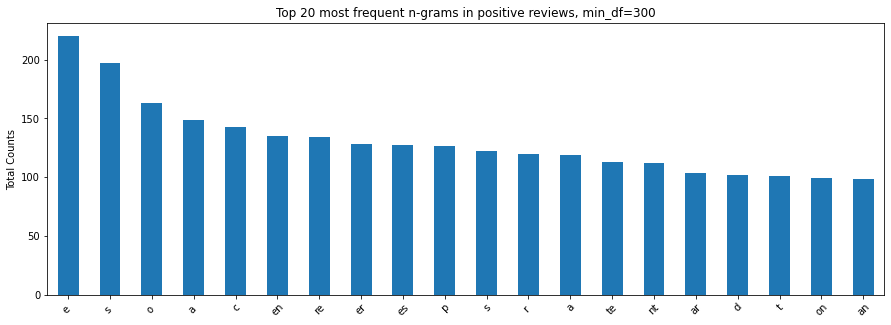

In [ ]:
charseq = pd.DataFrame(
    {"tfidf": X.toarray().sum(axis=0)},
    index=vect.get_feature_names()
).sort_values("tfidf", ascending=False)

charseq.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequent n-grams in positive reviews, min_df=300")
plt.ylabel("Total Counts")
plt.xticks(rotation=45)
plt.show()

In [ ]:
features_with_space = [seq for seq in vect.get_feature_names_out() if (' ' in seq)]

In [ ]:
len(features_with_space)

866

In [ ]:
indices = [list(vect.get_feature_names_out()).index(seq) for seq in features_with_space]

In [ ]:
len(indices)

866

In [ ]:
features_nospaces = [seq for seq in list(vect.get_feature_names_out()) if ' ' not in seq]

In [ ]:
len(features_nospaces)

2134

In [ ]:
2134+866

3000

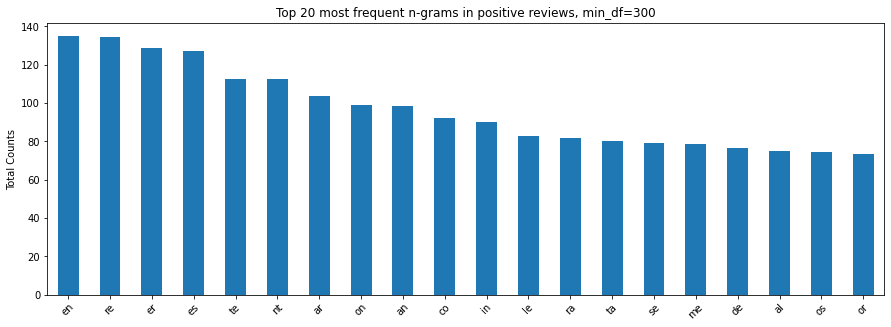

In [ ]:
X_nospaces = X[:,[ind for ind in range(X.shape[1]) if ind not in indices]].toarray()
charseq = pd.DataFrame(
    {"tfidf": X_nospaces.sum(axis=0)},
    index=features_nospaces
).sort_values("tfidf", ascending=False)

charseq.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequent n-grams in positive reviews, min_df=300")
plt.ylabel("Total Counts")
plt.xticks(rotation=45)
plt.show()

In [ ]:
all_lexemes = all_lexemes.reset_index()

In [ ]:
all_lexemes = pd.concat([all_lexemes,pd.DataFrame(X_nospaces,columns=features_nospaces)],axis=1)

In [ ]:
all_lexemes.columns

Index(['index', 'lexeme_id', 'learning_language', 'lexeme_string',
       'surface_form', 'lemma_form', 'pos', 'modstrings', 'sf_length',
       'mod_*gndr',
       ...
       'êt', 'ête', 'ía', 'ían', 'ías', 'ín', 'ît', 'ña', 'ño', 'ón'],
      dtype='object', length=2231)

We have 2233 word based features in all_lexemes. we will save this to the word features file. 

In [ ]:
compressed_pickle(path_name+"q1_lexeme_features",all_lexemes)

We purposely vectorized before splitting because we don't want to get thrown unknown features yet. 

Dataset types:

1. no student information
2. timestamp based student based features?

EDA

In [ ]:

# this errors out for lack of space even with high-RAM
# datadfq1_1 = pd.merge(left = datadfq1,right = all_lexemes, how="left",left_on = 'lexeme_id',right_on = 'lexeme_id')

In [ ]:
datadfq1_1.shape, 

We;re running into issues joining datadfq_1 (Unseen_words_training_set.pbz2)with the all_lexemes dataet. (saved in q1_lexeme_features.pbz2)

Will try the following in the next dataset.
0. try doing some descriptive EDAs (statistical tests two sample t-test as well as Mann Whitney U) 
1. change rest of datadfq1 numerics to sparse dataset
2. try PCA with lexeme features and then joining (bring down to 200 or so)